In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as D
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from cutbayesflow import CutBayesFlow, train_cut_bayes_flow
from cutbayesflow.utils import get_marginal_samples

# ─────────────────────────────────────────────
# 0) Reproducibility & Common Settings
# ─────────────────────────────────────────────
seed = 1010
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = "cpu"

# Prior on eta: Gamma(2,1)
alpha, beta = 2.0, 1.0
eta_dist = D.Gamma(concentration=alpha, rate=beta)
N_MC = 1000
# fixed eta samples for both models
eta_samples = eta_dist.sample((N_MC,1))

# Grid for plotting
theta_grid = torch.linspace(-8,8,500).unsqueeze(1)

# ─────────────────────────────────────────────
# 1) Mixture‑of‑Gaussians target definitions
# ─────────────────────────────────────────────
def pi1_fn(eta):
    # Sharper change in mixture weights
    return (0.2 + 0.5 * torch.sigmoid(4 * (eta - 2.0))).clamp(1e-6, 1-1e-6)

def mu1_fn(eta):
    # Larger swings in mean for component 1
    return 4.0 * torch.tanh(eta - 1.0)

def mu2_fn(eta):
    # Larger swings in mean for component 2
    return -4.0 * torch.tanh(eta + 1.0)

sigma1, sigma2 = 1.5, 1.5  # Fixed variances

def posterior_log_p_theta_given_eta(theta, eta, data=None):
    p1 = torch.exp(D.Normal(mu1_fn(eta), sigma1).log_prob(theta))
    p2 = torch.exp(D.Normal(mu2_fn(eta), sigma2).log_prob(theta))
    return torch.log(pi1_fn(eta) * p1 + (1 - pi1_fn(eta)) * p2 + 1e-8)

def dummy_prior(theta):
    return torch.zeros(theta.size(0))

# true marginal p(theta) (MC over eta_samples)
with torch.no_grad():
    theta = theta_grid.expand(-1,N_MC)
    eta = eta_samples.t().expand(theta_grid.size(0),-1)
    log_mix = posterior_log_p_theta_given_eta(theta,eta)
    log_p_marg = torch.logsumexp(log_mix, dim=1) - torch.log(torch.tensor(N_MC,dtype=torch.float))
    p_theta_true = torch.exp(log_p_marg)

# ─────────────────────────────────────────────
# 2) Monotone Flow Model
# ─────────────────────────────────────────────
# --- Monotone Flow: θ = f(z; η) = a(η) + ∫_{t₀}^z h(t; η) dt, with h(t; η) = exp(g(t; η)) ---

# Shift network: computes a(η)
class ANet(nn.Module):
    def __init__(self, eta_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(eta_dim, hidden),
            nn.LeakyReLU(0.01),
            nn.Linear(hidden, hidden),
            nn.LeakyReLU(0.01),
            nn.Linear(hidden, 1)
        )
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, eta):
        return self.net(eta).squeeze(-1)


# Neural network for g(t; η), followed by exp → h(t; η) = exp(g(t; η))
class HNet(nn.Module):
    def __init__(self, eta_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1 + eta_dim, hidden),
            nn.LeakyReLU(0.01),
            nn.Linear(hidden, hidden),
            nn.LeakyReLU(0.01),
            nn.Linear(hidden, 1)
        )

    def forward(self, t, eta):
        B, N = t.shape
        inp = torch.cat([t.unsqueeze(-1), eta.unsqueeze(1).expand(B, N, -1)], dim=-1)
        g_output = self.net(inp).squeeze(-1)  # g(t; η)
        return torch.exp(g_output)  # h(t; η) = exp(g(t; η))


# Monotonic transformation: f(z; η) = a(η) + ∫_{t₀}^z h(t; η) dt
class MonotoneFlow(nn.Module):
    def __init__(self, eta_dim, t0=0.0, steps=500):
        super().__init__()
        self.a = ANet(eta_dim)
        self.h = HNet(eta_dim)  # h(t; η) = exp(g(t; η))
        self.t0 = t0
        self.register_buffer('u', torch.linspace(0, 1, steps))  # grid on [0,1]

    def forward(self, z, eta, return_derivative=False):
        B = z.size(0)
        z = z.squeeze(-1)
        t0, z0 = self.t0, z

        # Rescaled integration points: t = t₀ + (z - t₀) * u
        tg = t0 + (z0 - t0).unsqueeze(1) * self.u.unsqueeze(0)  # shape [B, steps]
        hv = self.h(tg, eta)  # h(t; η)

        # Trapezoidal rule for ∫ h(t; η) dt over [t₀, z]
        du = 1 / (self.u.size(0) - 1)
        trap = 0.5 * (hv[:, :-1] + hv[:, 1:]) * du
        integral = trap.sum(1) * (z0 - t0)

        a = self.a(eta)
        theta = a + integral

        if return_derivative:
            hz = self.h(z.unsqueeze(1), eta).squeeze(-1)  # h(z; η)
            return theta, hz
        return theta


# instantiate & train monotone
mono_epochs = 2000
model_mono=MonotoneFlow(eta_dim=1, t0=0.0).to(device)
opt_mono=optim.Adam(model_mono.parameters(),lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(opt_mono, step_size=250, gamma=0.75)

def kl_mono(z,theta,dz,eta):
    logqz=D.Normal(0,1).log_prob(z).sum(-1)
    logq=logqz-torch.log(dz.clamp(min=1e-8))
    logp=posterior_log_p_theta_given_eta(theta,eta)
    return (logq-logp).mean()

print("Training Monotone NN")

for ep in range(mono_epochs):
    z=torch.randn(N_MC,1)
    idx=torch.randint(0,N_MC,(N_MC,))
    eta_b=eta_samples[idx]
    theta,dz=model_mono(z,eta_b,True)
    loss=kl_mono(z.squeeze(-1),theta,dz,eta_b.squeeze(-1))
    opt_mono.zero_grad();
    loss.backward();
    opt_mono.step()
    scheduler.step() 
    if ep % 200 == 0:
        with torch.no_grad():
            a_vals = model_mono.a(eta_b).cpu()
            print(f"Epoch {ep:4d} – KL = {loss.item():.4f}, "
                    f"a(eta) ∈ [{a_vals.min():.3f}, {a_vals.max():.3f}]")
            
print("Monotone NN is complete")

# ─────────────────────────────────────────────
# 3) NeVI Model (CutBayesFlow)
# ─────────────────────────────────────────────
print("Training NeVI")
model_nevi=CutBayesFlow(
    prior_log_prob_fn=dummy_prior,
    likelihood_log_prob_fn=posterior_log_p_theta_given_eta,
    eta_dim=1, theta_dim=1,
    num_layers=10, hidden_features=16,
    num_bins=25, tail_bound=15.0,
    use_residual_blocks=True, num_blocks=2
)

loss_history = train_cut_bayes_flow(
    model_nevi,
    eta_samples,
    None,
    epochs=2000,
    lr=5e-3,
    log_interval=200,
    seed=seed,
    verbose=True
)

print("NeVI is finished")

Training Monotone NN
Epoch    0 – KL = -1382.7052, a(eta) ∈ [-0.008, 0.005]
Epoch  200 – KL = -1415.0006, a(eta) ∈ [-3.511, 5.420]
Epoch  400 – KL = -1426.0380, a(eta) ∈ [-3.421, 4.248]
Epoch  600 – KL = -1402.5854, a(eta) ∈ [-3.379, 4.735]
Epoch  800 – KL = -1441.5212, a(eta) ∈ [-3.340, 4.096]
Epoch 1000 – KL = -1422.1567, a(eta) ∈ [-3.324, 3.906]
Epoch 1200 – KL = -1403.2747, a(eta) ∈ [-3.279, 4.079]
Epoch 1400 – KL = -1427.2335, a(eta) ∈ [-3.418, 4.041]
Epoch 1600 – KL = -1375.4805, a(eta) ∈ [-3.295, 4.128]
Epoch 1800 – KL = -1440.2117, a(eta) ∈ [-3.295, 4.247]
Monotone NN is complete
Training NeVI
Using batch_size=1000 (full-batch: True)
Step     0 | Loss: 13.928584 | LR: 5.00e-03
Epoch 00167: reducing learning rate of group 0 to 2.5000e-03.
Step   200 | Loss: 0.267475 | LR: 2.50e-03
Step   400 | Loss: 0.023461 | LR: 2.50e-03
Epoch 00517: reducing learning rate of group 0 to 1.2500e-03.
Step   600 | Loss: 0.017931 | LR: 1.25e-03
Epoch 00638: reducing learning rate of group 0 to 6.2

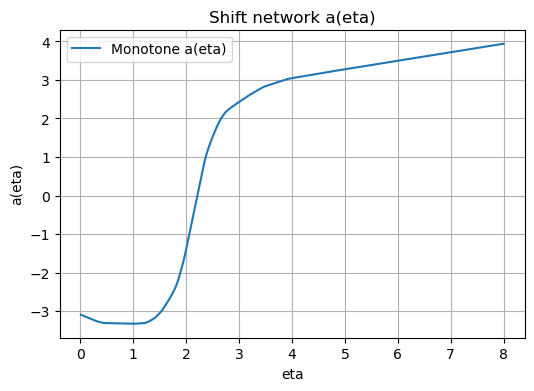

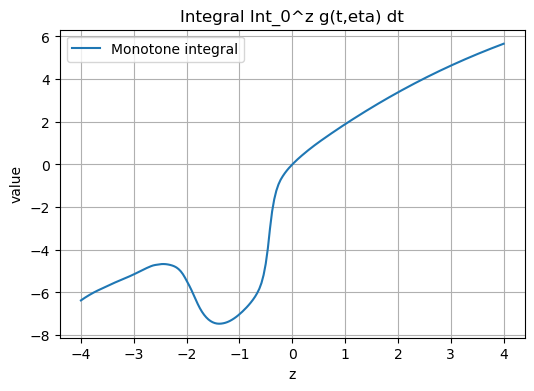

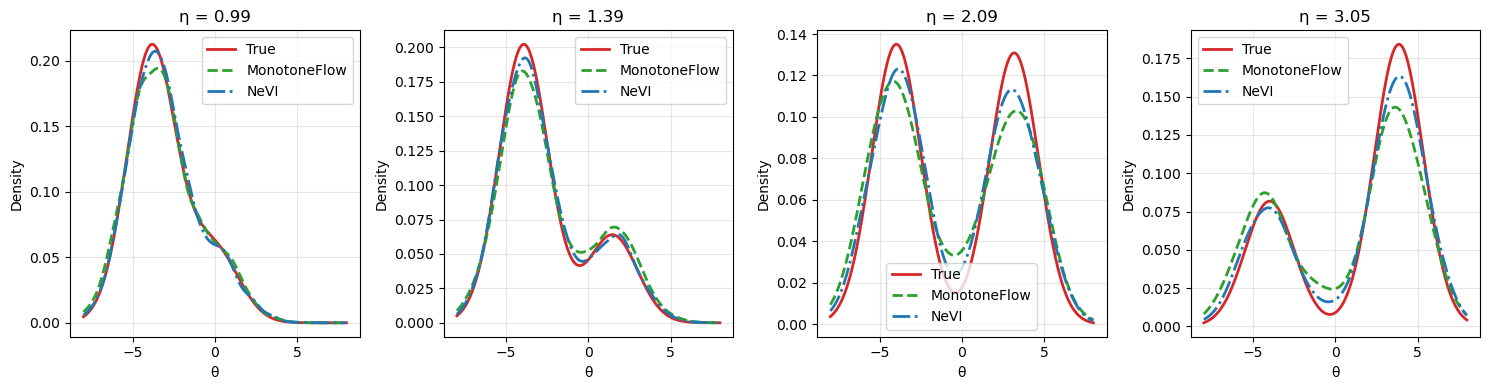

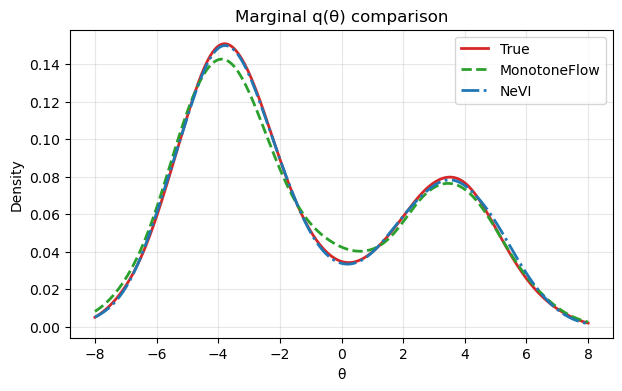

In [4]:
seed = 1010
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# ─────────────────────────────────────────────
# 4) Diagnostics & Comparison Plots
# ─────────────────────────────────────────────
# a(eta)
eta_grid=torch.linspace(0.01,8,200).unsqueeze(1)
with torch.no_grad():
    a_mono=model_mono.a(eta_grid)
    # NeVI has no a(eta) to plot
plt.figure(figsize=(6,4))
plt.plot(eta_grid.numpy(),a_mono.numpy(),label='Monotone a(eta)')
plt.title('Shift network a(eta)')
plt.xlabel('eta');plt.ylabel('a(eta)');plt.legend();plt.grid();plt.show()

# integral for monotone
zg=torch.linspace(-4,4,200).unsqueeze(1)
eta_val=eta_grid[100]
with torch.no_grad():
    th=model_mono(zg,eta_grid[:200],False)
    iv=th - model_mono.a(eta_grid[:200])
plt.figure(figsize=(6,4))
plt.plot(zg.numpy().ravel(), iv.numpy().ravel(),label='Monotone integral')
plt.title('Integral Int_0^z g(t,eta) dt')
plt.xlabel('z');plt.ylabel('value');plt.legend();plt.grid();plt.show()


# 1) Define your color palette:
colors = {
    'True': '#D62728',   # deep red
    'Mono': '#2CA02C',   # green
    'NeVI': '#1F77B4',   # blue
}

# 2) Prepare the x‐axis once:
x = theta_grid.numpy().ravel()  # e.g. theta_grid = torch.linspace(-8,8,500).unsqueeze(1)

# Initialize containers before plots
conditional_samples = {}
conditional_truths = {}
eta_vals = [eta_samples.quantile(q, 0).item() for q in [0.25, 0.4, 0.6, 0.8]]

fig, axes = plt.subplots(1, len(eta_vals), figsize=(15, 4))
for ax, ev in zip(axes, eta_vals):
    with torch.no_grad():
        # True conditional
        logp = posterior_log_p_theta_given_eta(theta_grid, torch.full_like(theta_grid, ev))
        p_true = torch.exp(logp).numpy().ravel()
        conditional_truths[f"eta_{ev:.2f}_true"] = p_true

        # MonotoneFlow
        zt = torch.randn(5000, 1)
        qm = model_mono(zt, torch.full((5000, 1), ev)).numpy().ravel()
        conditional_samples[f"eta_{ev:.2f}_mono"] = qm

        # NeVI
        qt = model_nevi.sample_q_theta_given_eta(torch.full((5000, 1), ev)).detach().numpy().ravel()
        conditional_samples[f"eta_{ev:.2f}_nevi"] = qt

    # Plot
    ax.plot(x, p_true, color=colors['True'], linewidth=2, label='True')
    ax.plot(x, gaussian_kde(qm)(x), color=colors['Mono'], linestyle='--', linewidth=2, label='MonotoneFlow')
    ax.plot(x, gaussian_kde(qt)(x), color=colors['NeVI'], linestyle='-.', linewidth=2, label='NeVI')
    ax.set_title(f"η = {ev:.2f}")
    ax.set_xlabel("θ")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# Marginal samples (store once, use for plot and save)
with torch.no_grad():
    z_mono = torch.randn(10000, 1)
    idx = torch.randint(0, eta_samples.shape[0], (10000,))
    tm = model_mono(z_mono, eta_samples[idx]).numpy().ravel()
    tn = model_nevi.sample_q_theta_given_eta(eta_samples[idx]).detach().numpy().ravel()

# True marginal via sampling
true_marginal_samples = []
with torch.no_grad():
    for _ in range(10000):
        eta_i = eta_dist.sample().item()
        logp = posterior_log_p_theta_given_eta(theta_grid, torch.full_like(theta_grid, eta_i))
        p = torch.exp(logp).numpy().ravel()
        p /= p.sum()
        theta_sample = np.random.choice(x, p=p)
        true_marginal_samples.append(theta_sample)
marginal_true = np.array(true_marginal_samples)

# Plot
plt.figure(figsize=(7, 4))
plt.plot(x, gaussian_kde(marginal_true)(x), color=colors['True'], linewidth=2, label='True')
plt.plot(x, gaussian_kde(tm)(x), color=colors['Mono'], linestyle='--', linewidth=2, label='MonotoneFlow')
plt.plot(x, gaussian_kde(tn)(x), color=colors['NeVI'], linestyle='-.', linewidth=2, label='NeVI')
plt.title("Marginal q(θ) comparison")
plt.xlabel("θ")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Save exactly what was used for plotting
all_samples = {
    **conditional_samples,
    **conditional_truths,
    "marginal_mono": tm,
    "marginal_nevi": tn,
    "marginal_true": marginal_true,
    "theta_grid": x
}

np.savez("/Users/jiafangsong/Desktop/Cut_Bayes_VI/NeVI_paper_results/others/all_theta_samples.npz", **all_samples)

